In [52]:
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
import numpy as np

In [53]:
!pip install scikit-image opencv-python

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
!python --version
!pip3 install cellpose

Python 3.11.13


In [56]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Thu Jun 19 16:06:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0       

In [57]:
import pandas as pd
from cellpose import models, core, io, plot
import skimage
from pathlib import Path
from tqdm import trange
from natsort import natsorted
from scipy.spatial import KDTree
import cv2

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
#if core.use_gpu()==False:
#  raise ImportError("No GPU access, change your runtime")
#drive.mount('/content/drive')
model = models.CellposeModel(gpu=True)

2025-06-19 16:06:51,905 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-06-19 16:06:51,906 [INFO] 
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-06-19 16:06:51,908 [INFO] ** TORCH CUDA version installed and working. **
2025-06-19 16:06:51,925 [INFO] >>>> using GPU (CUDA)
2025-06-19 16:07:00,679 [INFO] >>>> loading model /root/.cellpose/models/cpsam


In [59]:
dir = '/content/drive/MyDrive/KI67/imagenes_Ruifrok/DAB'
#dir = '/Users/Win10/Documents/GitHub/Ki67development/data_de_prueba/images_40'
#dir = '/content/drive/MyDrive/DigitPatho/test_images'
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

image_ext = [".jpg", ".jpeg", ".png"]
# list all files
files = natsorted([f for f in dir.glob("*") if f.suffix in image_ext and "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

39 images in folder:
171335_KI_002_dab_auto.png
CD3805ed (P)_dab_auto.png
DPKI010_dab_auto.png
EVAPERON 15_dab_auto.png
EZE004 (5)_dab_auto.png
EZE007 (12)_dab_auto.png
EZE013 (6)_dab_auto.png
EZE015 (13) (P)_dab_auto.png
EZE020 (8) (P)_dab_auto.png
EZE26 (18)_dab_auto.png
EZE028 (2)_dab_auto.png
EZE036 (2)_dab_auto.png
EZE037 (5)_dab_auto.png
GM102 (P)_dab_auto.png
GM111 (P)_dab_auto.png
GM119 (P)_dab_auto.png
GM122 (P)_dab_auto.png
GM127 (P)_dab_auto.png
GM130 (P)_dab_auto.png
GM135 (P)_dab_auto.png
GM140 (P)_dab_auto.png
GM144 (P)_dab_auto.png
GM148 (P)_dab_auto.png
GM192(5) KI (P)_dab_auto.png
GM248(3)KI (P)_dab_auto.png
GM268(2) KI (P)_dab_auto.png
GM269(1) KI (P)_dab_auto.png
GM333(3) KI (P)_dab_auto.png
GM356(3) KI (P)_dab_auto.png
GM361(5) KI (P)_dab_auto.png
Ki67-400x-01 E Vogel (3)_dab_auto.png
Ki67-400x-01 E Vogel (7)_dab_auto.png
OU 353 (P)_dab_auto.png
OU 362 (P)_dab_auto.png
OU 369 (P)_dab_auto.png
OU 378 (P)_dab_auto.png
OU 388 (P)_dab_auto.png
OU 394 (P)_dab_auto.png
OU

In [60]:
# Cargar imágenes correctamente iterando sobre archivos, no índices
print("Cargando imágenes...")
imgs = [io.imread(str(f)) for f in files]
print(f"{len(imgs)} imágenes cargadas correctamente.")

Cargando imágenes...
39 imágenes cargadas correctamente.


In [76]:
from skimage.transform import resize
from skimage.color import rgb2gray
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, RobustScaler, QuantileTransformer
import cv2

def transform_image_rgb(image: np.ndarray, method: str = 'yeo-johnson') -> np.ndarray:
    """
    Aplica una transformación a una imagen RGB.

    Parametros:
    - image: imagen RGB como np.array de forma (H, W, 3).
    - method: ['box-cox', 'yeo-johnson', 'robust', 'quantile'].

    Resultado:
    - Imagen tranformada como np.array de tamaño (H, W, 3).
    """

    image = image.astype(np.float32)
    image = ( image -  image.min(axis=(0,1))) / (image.max(axis=(0,1)) - image.min(axis=(0,1)))

    H, W, C = image.shape
    reshaped = image.reshape(-1, C)

    if method in ['box-cox', 'yeo-johnson']:
        transformer = PowerTransformer(method=method)
        # box-cox EXIGE que sea positivo
        if method == 'box-cox':
            reshaped += 1e-5
        transformed = transformer.fit_transform(reshaped)

    elif method == 'robust':
        scaler = RobustScaler()
        transformed = scaler.fit_transform(reshaped)

    elif method == 'quantile':
        transformer = QuantileTransformer(output_distribution='normal', random_state=42)
        transformed = transformer.fit_transform(reshaped)

    elif method == 'log':
        transformed = np.log1p(reshaped**4)
    elif method == 'null':
        reshaped /= image.max()
        transformed = reshaped

    else:
        raise ValueError("Metodo no implementado. Puede elegir entre 'box-cox', 'yeo-johnson', 'robust', 'quantile' y 'log( 1 + x**3 )' ")

    transformed = transformed.reshape(H, W, C)
    #transformed = (transformed - transformed.min()) / (transformed.max() - transformed.min())
    transformed = ( transformed -  transformed.min(axis=(0,1))) / (transformed.max(axis=(0,1)) - transformed.min(axis=(0,1)))


    return transformed.astype(np.float32)

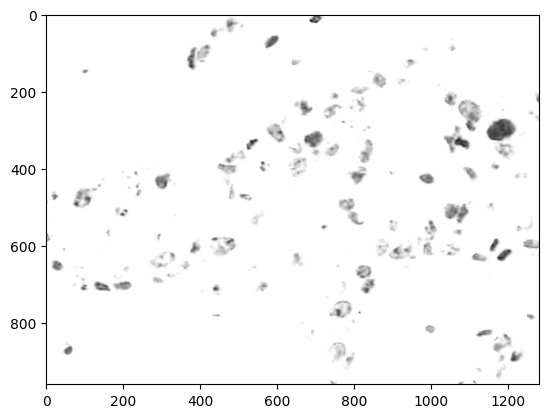

In [77]:
from skimage.transform import resize
from skimage.color import rgb2gray
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import cv2
resized_imgs = []

for img in imgs:
    if img.ndim == 2:
        img = gray2rgb(img)  # Convertir a 3 canales si es escala de grises
    elif img.shape[2] == 4:
        img = rgba2rgb(img)  # Convertir RGBA a RGB

    img = img.astype(np.float32)
    transformed = transform_image_rgb(img, method='null')
    resized_imgs.append(transformed)

# resized_imgs = []

# # standardize=False → skip the zero-mean unit-variance scaling at the end,
# # so we only see the λ‐power transformation itself.


# for img in imgs:
#     img = img.astype(np.float32)
#     transformed = transform_image_rgb(img, method='null' )
#     resized_imgs.append(transformed)
plt.imshow(transformed, cmap='gray')
plt.show()

In [78]:
import ipywidgets as widgets
from IPython.display import display

first_channel = widgets.Dropdown(
    options=[None, 0, 1, 2, 3, 4, 5],
    value=1,
    description='Canal 1:',
)

second_channel = widgets.Dropdown(
    options=[None, 0, 1, 2, 3, 4, 5],
    value=0,
    description='Canal 2:',
)

third_channel = widgets.Dropdown(
    options=[None, 0, 1, 2, 3, 4, 5],
    value=2,
    description='Canal 3:',
)

display(first_channel, second_channel, third_channel)

Dropdown(description='Canal 1:', index=2, options=(None, 0, 1, 2, 3, 4, 5), value=1)

Dropdown(description='Canal 2:', index=1, options=(None, 0, 1, 2, 3, 4, 5), value=0)

Dropdown(description='Canal 3:', index=3, options=(None, 0, 1, 2, 3, 4, 5), value=2)

In [79]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Aplicar CLAHE solo en el canal azul (es el canal 2 en RGB)
imgs_clahe = []
for img in resized_imgs:
    img_clahe = img.copy()
    img = (img*255).astype(np.uint8)
    img_clahe[:, :, 2] = clahe.apply(img[:, :, 2])  # Aplicar CLAHE en canal azul
    imgs_clahe.append(img_clahe)

print("CLAHE aplicado al canal azul en todas las imágenes.")

CLAHE aplicado al canal azul en todas las imágenes.


In [80]:
import time
from tqdm import tqdm

start_time = time.time()

# Aplicar selección de canales a todas las imágenes
#imgs_selected_channels = [img[:, :, selected_channels] for img in imgs]



diameter=None # Estima el tamaño automáticamente
flow_threshold=0.2
cellprob_threshold=0.5
tile_norm_blocksize=512 # Mejora la captura de detalles


# Ejecutar Cellpose-SAM con imágenes procesadas
masks, flows, styles = model.eval(imgs_clahe, batch_size=32, flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold, diameter=diameter,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

# Calcular tiempo total de ejecución
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tiempo total de procesamiento: {elapsed_time:.2f} segundos")

2025-06-19 16:28:19,209 [INFO] 100%|##########| 39/39 [11:46<00:00, 18.12s/it]
Tiempo total de procesamiento: 706.66 segundos


2025-06-19 16:32:20,373 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
2025-06-19 16:32:23,642 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


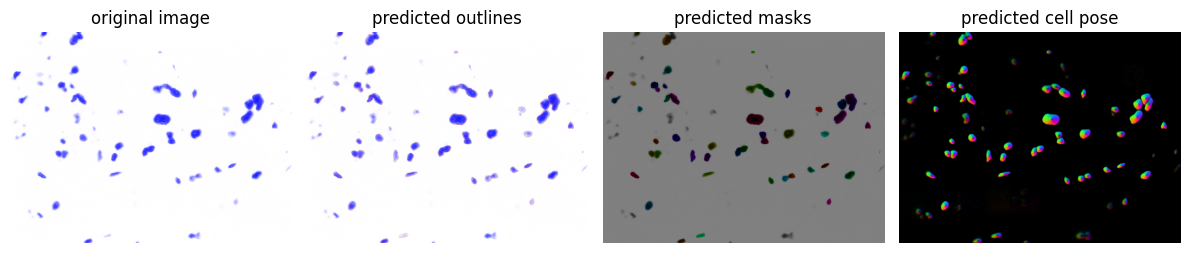

In [85]:
## Grafico solo la primer imagen
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, imgs_clahe[0], masks[0], flows[0][0])
plt.tight_layout()
plt.show()

In [86]:
# Definir el directorio donde se guardarán las máscaras
masks_dir = Path('/content/drive/MyDrive/KI67/imagenes_Ruifrok/masks')
# masks_dir = Path("/Users/Win10/Documents/GitHub/Ki67development/data_de_prueba/masks")
#masks_dir = Path('/content/drive/MyDrive/DigitPatho/masks_test6')
# Crear la carpeta si no existe
masks_dir.mkdir(parents=True, exist_ok=True)

masks_ext = ".png" if image_ext == ".png" else ".tif"
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]


print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(masks_dir / (f.stem + masks_ext), masks[i])

print(f"Máscaras guardadas en {masks_dir}")

"""
# Guardado de ROIs
for i, mask in enumerate(masks):
    roi_path = masks_dir / (f.stem + f"_roi_{i}" + masks_ext)
    print(f"ROI {i} guardada en {roi_path}")
"""
# Toma las masks guardadas y genera una lista
#mask_folder = "/content/drive/MyDrive/DigitPatho/masks_test6/"
# mask_folder = "/Users/Win10/Documents/GitHub/Ki67development/data_de_prueba/masks"
mask_folder = "/content/drive/MyDrive/KI67/imagenes_Ruifrok/masks"
mask_files = glob(os.path.join(masks_dir, "*.tif"))

# Cargar todas las máscaras en una lista
masks = []
for mask_file in mask_files:
    mask = io.imread(mask_file)
    if mask.ndim != 2:
        print(f"Warning: Mask file {os.path.basename(mask_file)} is not 2D. Shape: {mask.shape}. Skipping or investigating.")
        continue
    masks.append(mask)

loading images


100%|██████████| 39/39 [00:01<00:00, 32.97it/s]


saving masks


100%|██████████| 39/39 [00:00<00:00, 41.95it/s]


Máscaras guardadas en /content/drive/MyDrive/KI67/imagenes_Ruifrok/masks


In [87]:
from skimage.measure import regionprops
#centroides de masks

centroids = []
for i, mask in enumerate(masks):
    mask_np = np.array(mask)
    print(f"Máscara {i}: Dimensiones {mask_np.shape}, Tipo {mask_np.dtype}")

    # Verificar que sea una imagen 2D y tenga regiones segmentadas
    if mask_np.ndim == 2 and np.any(mask_np):
        props = regionprops(mask_np)
        for prop in props:
            centroids.append((prop.centroid[1], prop.centroid[0]))  # (x, y)
    else:
        print(f"⚠️ Advertencia: Saltando máscara {i} debido a dimensiones incorrectas o máscara vacía.")

# Construir KDTree si hay centroides válidos
if centroids:
    centroids = np.array(centroids, dtype=np.float32)  # Convertir a NumPy array
    tree = KDTree(centroids)
    print(f"KDTree construido con {len(centroids)} centroides.")
else:
    print("No se encontraron centroides, KDTree no será construido.")

Máscara 0: Dimensiones (1536, 2048), Tipo uint16
Máscara 1: Dimensiones (1879, 1620), Tipo uint16
Máscara 2: Dimensiones (1536, 2048), Tipo uint16
Máscara 3: Dimensiones (1455, 1600), Tipo uint16
Máscara 4: Dimensiones (720, 1280), Tipo uint16
Máscara 5: Dimensiones (720, 1280), Tipo uint16
Máscara 6: Dimensiones (720, 1280), Tipo uint16
Máscara 7: Dimensiones (720, 1280), Tipo uint16
Máscara 8: Dimensiones (720, 1280), Tipo uint16
Máscara 9: Dimensiones (720, 1280), Tipo uint16
Máscara 10: Dimensiones (720, 1280), Tipo uint16
Máscara 11: Dimensiones (720, 1280), Tipo uint16
Máscara 12: Dimensiones (720, 1280), Tipo uint16
Máscara 13: Dimensiones (1536, 2048), Tipo uint16
Máscara 14: Dimensiones (1536, 2048), Tipo uint16
Máscara 15: Dimensiones (1536, 2048), Tipo uint16
Máscara 16: Dimensiones (1536, 2048), Tipo uint16
Máscara 17: Dimensiones (1536, 2048), Tipo uint16
Máscara 18: Dimensiones (1536, 2048), Tipo uint16
Máscara 19: Dimensiones (1536, 2048), Tipo uint16
Máscara 20: Dimensi

In [88]:
### Lectura de anotaciones

annotations_folder = "/content/drive/MyDrive/KI67/train_dataset_40/annotations"
# annotations_folder = "/Users/Win10/Documents/GitHub/Ki67development/data_de_prueba/annotations_40/"
#annotations_folder = "/content/drive/MyDrive/DigitPatho/annotations_test/"
annotations_files = glob(os.path.join(annotations_folder, "*.csv"))

# Crear un diccionario que asocie cada máscara con su nombre de archivo sin extensión
mask_dict = {}
# for mask_file in mask_files:
#     base_name = os.path.splitext(os.path.basename(mask_file))[0]
#     mask = io.imread(mask_file)
#     if mask.ndim == 2:
#         mask_dict[base_name] = mask
#     else:
#         print(f"Advertencia: Archivo de máscara {os.path.basename(mask_file)} no es 2D ({mask.shape}). Saltando.")
for mask_file in mask_files:
    base_name = os.path.splitext(os.path.basename(mask_file))[0]

    # ✅ Remover sufijo "_dab_auto" si está presente
    base_name = base_name.replace("_dab_auto", "")

    mask = io.imread(mask_file)
    if mask.ndim == 2:
        mask_dict[base_name] = mask
    else:
        print(f"Advertencia: Archivo de máscara {os.path.basename(mask_file)} no es 2D ({mask.shape}). Saltando.")

# Iterar sobre los archivos de anotaciones asegurando la correspondencia con la máscara correcta
metrics_dict = {}
for csv_path in annotations_files:
    base_name = os.path.splitext(os.path.basename(csv_path))[0]

    if base_name in mask_dict:
        mask = mask_dict[base_name]

        def read_points(csv_path):
            df = pd.read_csv(csv_path)
            if not all(col in df.columns for col in ["X", "Y", "Label"]):
                raise ValueError("CSV file must contain columns 'X', 'Y', and 'Label'.")

            x_coords = df["X"].values
            y_coords = df["Y"].values
            labels = df["Label"].values

            return x_coords, y_coords, labels

        x_coords, y_coords, labels = read_points(csv_path)
        annotation_coords = np.column_stack((x_coords, y_coords))

        # Asignar colores según la clasificación
        colors = np.where(labels == "Positivo", "red", "green")  # Rojo para positivos, verde para negativos

        centroids_for_current_mask = []
        props = regionprops(mask)
        for prop in props:
             # Append centroid (x, y) where x is column (second element) and y is row (first element)
            centroids_for_current_mask.append((prop.centroid[1], prop.centroid[0]))

        # Building a KDTree with the centroids of the current mask
        if centroids_for_current_mask:
            tree = KDTree(np.array(centroids_for_current_mask))
            # Asociar cada anotación con su núcleo más cercano
            distances, nearest_indices = tree.query(annotation_coords, distance_upper_bound=15)

            # Calcular TP, FP y FN
            TP = np.sum(distances < 15)  # Anotaciones correctamente asignadas
            FN = np.sum(distances >= 15)  # Anotaciones sin núcleo cercano
            FP = len(centroids_for_current_mask) - TP  # Núcleos segmentados sin anotaciones

            # Calcular métricas
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            # Guardar métricas por imagen
            metrics_dict[base_name] = {"Precision": precision, "Recall": recall, "F1-score": f1_score}


        else:
            print(f"No se encontraron centroides para la imagen {base_name}.")

# Convertir resultados a DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient="index")
#print(metrics_df)

print("Median F1-score: ", metrics_df["F1-score"].median())
print("Median Precision: ", metrics_df["Precision"].median())
print("Median Recall: ", metrics_df["Recall"].median())
# print("Archivos de anotaciones encontrados:", len(annotations_files))
# print("Máscaras cargadas:", len(mask_dict))

# print("Nombres de anotaciones:")
# print([os.path.splitext(os.path.basename(f))[0] for f in annotations_files])

# print("Nombres de máscaras:")
# print(list(mask_dict.keys()))

No se encontraron centroides para la imagen OU 353 (P).
Median F1-score:  0.24739393840292373
Median Precision:  0.9558441558441559
Median Recall:  0.14152770421728966


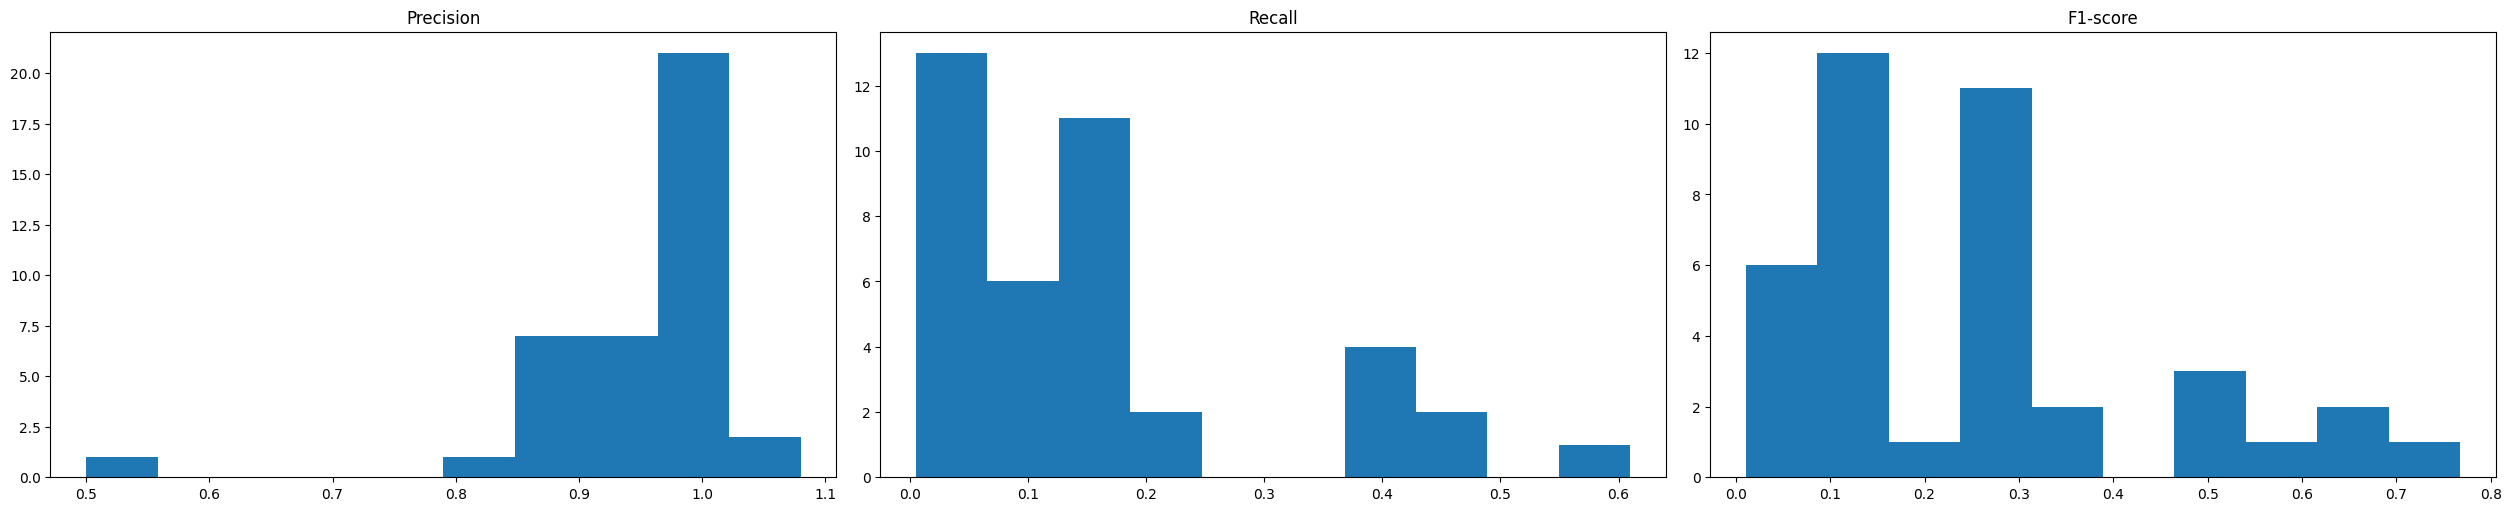

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5), constrained_layout=True)

axs[0].hist(metrics_df["Precision"])
axs[0].set_title("Precision")

axs[1].hist(metrics_df["Recall"])
axs[1].set_title("Recall")

axs[2].hist(metrics_df["F1-score"])
axs[2].set_title("F1-score")

plt.show()

In [29]:
import os
import skimage.io


# Lista de nombres de archivos de imagen en tu conjunto de prueba
image_folder = "/content/drive/MyDrive/KI67/imagenes_Ruifrok/DAB"
# image_folder = "/Users/Win10/Documents/GitHub/Ki67development/data_de_prueba/images_40"
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpg")]

# Iterar sobre cada imagen y generar gráficos
for img_path in image_paths:
    original_img = skimage.io.imread(img_path)
    base_name = os.path.basename(img_path).replace(".jpg", "")

    # Cargar anotaciones
    csv_path = os.path.join(annotations_folder, f"{base_name}.csv")
    if os.path.exists(csv_path):
        x_coords, y_coords, labels = read_points(csv_path)
        colors = ["red" if label == "Positivo" else "green" for label in labels]
    else:
        print(f"⚠️ No se encontró un archivo de anotaciones para {base_name}")
        x_coords, y_coords, colors = [], [], []


    plt.figure(figsize=(10, 5))

    # Imagen Original
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Imagen Original: {base_name}")

    # Máscara + Anotaciones
    plt.subplot(1, 2, 2)
    if base_name in mask_dict:
        plt.imshow(mask_dict[base_name], cmap="gray")
        plt.scatter(x_coords, y_coords, c=colors, marker="o", s=2)
        plt.imshow(mask_dict[base_name], alpha=0.5, cmap="jet")  # Superposición de colores
    else:
        print(f"⚠️ No se encontró máscara para {base_name}")

    plt.title(f"Validación para {base_name}")


    # Mostrar cada par de imágenes antes de continuar con la siguiente
    plt.show()

In [30]:
## Preparacion de df

#Extraccion de caracteristicas
import skimage.io
import skimage.measure
from pathlib import Path
import pandas as pd # Import pandas here

# Directorios de imágenes y máscaras
#image_dir = Path("/home/vanina/code/VaniBugatto/Ki67development/data_de_prueba/Test")

## Extraer solo datos de las segmentaciones
# mask_dir = Path("/Users/Win10/Documents/GitHub/Ki67development/data_de_prueba/masks")
mask_dir = Path("/content/drive/MyDrive/KI67/imagenes_Ruifrok/masks")

#image_dir = Path("/content/drive/MyDrive/DigitPatho/test_images")
#mask_dir = Path("/content/drive/MyDrive/DigitPatho/masks_test6")
# Lista de archivos de imágenes y máscaras
#image_files = sorted(image_dir.glob("*.jpg"))
mask_files = sorted(mask_dir.glob("*.tif"))

features = []  # Lista para almacenar características
centroids = []
# Iterate over images and their corresponding masks
for mask_path in mask_files:
    # Load image and mask
    #original_img = skimage.io.imread(img_path)
    masks = skimage.io.imread(str(mask_path))

    # Extraer características de cada región segmentada
    # Pass the loaded original_img as intensity_image
    for region in skimage.measure.regionprops(masks):
        # Extract intensity values for each channel
        features.append([
        mask_path.name,  # Nombre de la imagen
        region.area,  # Tamaño del núcleo
        region.perimeter,  # Perímetro
        region.eccentricity,  # Forma
        region.solidity,  # Compacidad
        region.centroid[1],  # Coordenada X
        region.centroid[0],  # Coordenada Y
        region.major_axis_length,  # Longitud del eje mayor
        region.minor_axis_length,  # Longitud del eje menor
        region.orientation,  # Orientación del núcleo
        region.extent,  # Ratio de cobertura
        region.convex_area,  # Área convexa del núcleo
                ])

        centroids.append(region.centroid)  # Guardar posición para calcular distancia

# **Calcular proximidad entre núcleos**
if len(centroids) > 1:
    kdtree = KDTree(centroids)
    min_distances = kdtree.query(centroids, k=2)[0][:, 1]  # Distancia al vecino más cercano

    # Agregar a la lista de características
    for i in range(len(features)):
        features[i].append(min_distances[i])

# Convertir a DataFrame
columns = ["imagen", "area", "perimetro", "excentricidad", "solidez", "X", "Y",
           "eje_mayor", "eje_menor", "orientacion", "extent", "area_convexa", "distancia_vecino"]
df = pd.DataFrame(features, columns=columns)

In [31]:
# Crear DataFrame con las características extraídas
df = pd.DataFrame(features, columns=columns)

#Guardar como archivo CSV
df.to_csv("/content/drive/MyDrive/KI67/imagenes_Ruifrok/dataset_caracteristicas.csv", index=False)
# df.to_csv("/Users/Win10/Documents/GitHub/Ki67development/data_de_prueba/dataset_caracteristicas6.csv", index=False)

#df.to_csv("/content/drive/MyDrive/DigitPatho/dataset_caracteristicas6.csv", index=False)
print(f"Datos guardados en dataset_caracteristicas.csv ({len(df)} registros)")

df.head()

Datos guardados en dataset_caracteristicas.csv (2118 registros)


,imagen,area,perimetro,excentricidad,solidez,X,Y,eje_mayor,eje_menor,orientacion,extent,area_convexa,distancia_vecino
0,171335_KI_002_dab_auto.tif,871.0,114.669048,0.767427,0.961369,246.495982,12.382319,41.841443,26.826087,-1.407451,0.786811,906.0,7.484901
1,171335_KI_002_dab_auto.tif,3758.0,237.622366,0.677290,0.968806,462.803353,58.300426,81.110601,59.674384,-0.389313,0.711742,3879.0,33.127212
2,171335_KI_002_dab_auto.tif,472.0,82.769553,0.778686,0.959350,1088.468220,145.605932,31.001955,19.451069,-1.552824,0.761290,492.0,10.357122
3,171335_KI_002_dab_auto.tif,2667.0,208.409163,0.672174,0.942736,469.366329,277.388451,69.083019,51.148615,-0.814967,0.683145,2829.0,15.145853
4,171335_KI_002_dab_auto.tif,1982.0,187.338095,0.846549,0.934906,46.318365,311.734612,71.351079,37.980908,-0.670600,0.600606,2120.0,18.634420


In [32]:
df[["X", "Y"]] = df[["X", "Y"]].astype(int)
df.head()

,imagen,area,perimetro,excentricidad,solidez,X,Y,eje_mayor,eje_menor,orientacion,extent,area_convexa,distancia_vecino
0,171335_KI_002_dab_auto.tif,871.0,114.669048,0.767427,0.961369,246,12,41.841443,26.826087,-1.407451,0.786811,906.0,7.484901
1,171335_KI_002_dab_auto.tif,3758.0,237.622366,0.677290,0.968806,462,58,81.110601,59.674384,-0.389313,0.711742,3879.0,33.127212
2,171335_KI_002_dab_auto.tif,472.0,82.769553,0.778686,0.959350,1088,145,31.001955,19.451069,-1.552824,0.761290,492.0,10.357122
3,171335_KI_002_dab_auto.tif,2667.0,208.409163,0.672174,0.942736,469,277,69.083019,51.148615,-0.814967,0.683145,2829.0,15.145853
4,171335_KI_002_dab_auto.tif,1982.0,187.338095,0.846549,0.934906,46,311,71.351079,37.980908,-0.670600,0.600606,2120.0,18.634420


In [33]:
# Carpeta de anotaciones
annotations_folder = "/content/drive/MyDrive/KI67/train_dataset_40/annotations"
# annotations_folder = "/Users/Win10/Documents/GitHub/Ki67development/data_de_prueba/annotations_40/"
#annotations_folder = "/content/drive/MyDrive/DigitPatho/annotations_test/"
annotations_files = glob(os.path.join(annotations_folder, "*.csv"))

# Unir todas las anotaciones en un solo DataFrame
annotations_list = [pd.read_csv(csv_file) for csv_file in annotations_files]
annotations = pd.concat(annotations_list, ignore_index=True)

# Verificar que el DataFrame combinado tenga las columnas esperadas
print(annotations.head())
print(annotations.columns)

len(annotations)

     X    Y     Label
0  883  572  Positivo
1  936  593  Negativo
2   26  124  Negativo
3  939  518  Negativo
4  394  318  Negativo
Index(['X', 'Y', 'Label'], dtype='object')


14495

In [34]:
print(annotations_files)

['/content/drive/MyDrive/KI67/train_dataset_40/annotations/EZE26 (18).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/EZE028 (2).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/EZE036 (2).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/EZE037 (5).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/EZE007 (12).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/EZE013 (6).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/EZE004 (5).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/EZE015 (13) (P).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/EZE020 (8) (P).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/GM119 (P).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/GM122 (P).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/GM127 (P).csv', '/content/drive/MyDrive/KI67/train_dataset_40/annotations/GM130 (P).csv', '/content/drive/My

In [35]:
#Calcular proporcion de cada anotacion
cantidad_positivos = (annotations['Label'] == 'Positivo').sum()
cantidad_negativos = (annotations['Label'] == 'Negativo').sum()
cantidad_no_importante = (annotations['Label'] == 'No importante').sum()

proporcion_positivos = cantidad_positivos / len(annotations)
proporcion_negativos = cantidad_negativos / len(annotations)
proporcion_no_importante = cantidad_no_importante / len(annotations)
print(f"Cantidad de positivos: {cantidad_positivos:.2f}")
print(f"Cantidad de negativos: {cantidad_negativos:.2f}")
print(f"Cantidad de no importantes: {cantidad_no_importante:.2f}")
print(f"Proporcion de positivos: {proporcion_positivos:.2f}")
print(f"Proporcion de negativos: {proporcion_negativos:.2f}")
print(f"Proporcion de no importantes: {proporcion_no_importante:.2f}")

Cantidad de positivos: 3245.00
Cantidad de negativos: 8908.00
Cantidad de no importantes: 2342.00
Proporcion de positivos: 0.22
Proporcion de negativos: 0.61
Proporcion de no importantes: 0.16


In [37]:
# Lista de archivos de anotaciones con rutas completas
label_files = annotations_files  # Lista con rutas completas de los archivos CSV

# Crear un diccionario que mapea nombres de imágenes (sin .tif) a rutas de archivos CSV
label_files_dict = {os.path.basename(file).replace(".csv", ""): file for file in label_files}

# Diccionario para asignar etiquetas
labels_dict = {}

# **Eliminar la extensión .tif de los nombres en df**
# df["imagen_sin_tif"] = df["imagen"].str.replace(".tif", "", regex=False)
df["imagen_sin_tif"] = df["imagen"].str.replace(".tif", "", regex=False).str.replace("_dab_auto", "", regex=False)


# Iterar sobre cada imagen en el DataFrame
for imagen in df["imagen_sin_tif"].unique():
    # Buscar el archivo CSV correspondiente a la imagen
    label_file = label_files_dict.get(imagen, None)
    if label_file is None:
        print(f"⚠️ Advertencia: No se encontró un archivo CSV para la imagen {imagen}.")
        continue  # Saltar si no hay archivo correspondiente

    # Cargar el archivo de labels
    labels = pd.read_csv(label_file)

    # Verificar que el CSV tiene las columnas necesarias
    if not {"X", "Y", "Label"}.issubset(annotations.columns):
        print(f"⚠️ Advertencia: El archivo {label_file} no tiene las columnas necesarias.")
        continue

    # Filtrar los datos de df para la imagen actual
    df_img = df[df["imagen_sin_tif"] == imagen]

    if df_img.empty:
        print(f"⚠️ Advertencia: No se encontraron registros en df para la imagen {imagen}.")
        continue

    # Extraer coordenadas de los núcleos segmentados
    segment_centroids = np.array(df_img[["X", "Y"]].values)

    # Extraer coordenadas de las anotaciones
    annotation_coords = np.array(labels[["X", "Y"]].values)

    # Crear árbol KDTree para encontrar coincidencias aproximadas
    tree = KDTree(segment_centroids)

    # **Aumentar la tolerancia de distancia**
    _, nearest_indices = tree.query(annotation_coords, distance_upper_bound=20)  # Ajusta tolerancia si es necesario

    # **Verificar los índices obtenidos**
    #print(f"🔍 Índices obtenidos para la imagen {imagen}: {nearest_indices}")
    #print(f"🔍 Tamaño de annotations: {len(labels)}")

    # **Filtrar índices fuera de rango correctamente**
    valid_indices = [idx for idx in nearest_indices if 0 <= idx < len(labels)]

    if len(valid_indices) == 0:
        print(f"⚠️ Advertencia: No se encontraron anotaciones válidas para la imagen {imagen}.")
        continue

    # Filtrar anotaciones válidas
    annotations_valid = labels.iloc[valid_indices]

    # Ajustar tamaño si es necesario
    annotations_valid = annotations_valid.iloc[:len(df_img)]

    # Guardar en el diccionario
    labels_dict.update(dict(zip(df_img.index, annotations_valid["Label"].values)))

# Asignar los labels al DataFrame
df["Label"] = df.index.map(labels_dict)

In [38]:
df.head()

,imagen,area,perimetro,excentricidad,solidez,X,Y,eje_mayor,eje_menor,orientacion,extent,area_convexa,distancia_vecino,imagen_sin_tif,Label
0,171335_KI_002_dab_auto.tif,871.0,114.669048,0.767427,0.961369,246,12,41.841443,26.826087,-1.407451,0.786811,906.0,7.484901,171335_KI_002,Negativo
1,171335_KI_002_dab_auto.tif,3758.0,237.622366,0.677290,0.968806,462,58,81.110601,59.674384,-0.389313,0.711742,3879.0,33.127212,171335_KI_002,No importante
2,171335_KI_002_dab_auto.tif,472.0,82.769553,0.778686,0.959350,1088,145,31.001955,19.451069,-1.552824,0.761290,492.0,10.357122,171335_KI_002,No importante
3,171335_KI_002_dab_auto.tif,2667.0,208.409163,0.672174,0.942736,469,277,69.083019,51.148615,-0.814967,0.683145,2829.0,15.145853,171335_KI_002,No importante
4,171335_KI_002_dab_auto.tif,1982.0,187.338095,0.846549,0.934906,46,311,71.351079,37.980908,-0.670600,0.600606,2120.0,18.634420,171335_KI_002,No importante


In [39]:
print(df.isnull().sum())

imagen              0
area                0
perimetro           0
excentricidad       0
solidez             0
X                   0
Y                   0
eje_mayor           0
eje_menor           0
orientacion         0
extent              0
area_convexa        0
distancia_vecino    0
imagen_sin_tif      0
Label               0
dtype: int64


In [40]:
df.shape

(2118, 15)

In [41]:
df.set_index('imagen', inplace=True)

In [42]:
print(df['Label'])

imagen
171335_KI_002_dab_auto.tif         Negativo
171335_KI_002_dab_auto.tif    No importante
171335_KI_002_dab_auto.tif    No importante
171335_KI_002_dab_auto.tif    No importante
171335_KI_002_dab_auto.tif    No importante
                                  ...      
OU 399 (P)_dab_auto.tif       No importante
OU 399 (P)_dab_auto.tif       No importante
OU 399 (P)_dab_auto.tif       No importante
OU 399 (P)_dab_auto.tif       No importante
OU 399 (P)_dab_auto.tif       No importante
Name: Label, Length: 2118, dtype: object


In [43]:
df.head()

,area,perimetro,excentricidad,solidez,X,Y,eje_mayor,eje_menor,orientacion,extent,area_convexa,distancia_vecino,imagen_sin_tif,Label
imagen,,,,,,,,,,,,,,
171335_KI_002_dab_auto.tif,871.0,114.669048,0.767427,0.961369,246,12,41.841443,26.826087,-1.407451,0.786811,906.0,7.484901,171335_KI_002,Negativo
171335_KI_002_dab_auto.tif,3758.0,237.622366,0.677290,0.968806,462,58,81.110601,59.674384,-0.389313,0.711742,3879.0,33.127212,171335_KI_002,No importante
171335_KI_002_dab_auto.tif,472.0,82.769553,0.778686,0.959350,1088,145,31.001955,19.451069,-1.552824,0.761290,492.0,10.357122,171335_KI_002,No importante
171335_KI_002_dab_auto.tif,2667.0,208.409163,0.672174,0.942736,469,277,69.083019,51.148615,-0.814967,0.683145,2829.0,15.145853,171335_KI_002,No importante
171335_KI_002_dab_auto.tif,1982.0,187.338095,0.846549,0.934906,46,311,71.351079,37.980908,-0.670600,0.600606,2120.0,18.634420,171335_KI_002,No importante


In [44]:
# Guardar el dataset con etiquetas
df.to_csv("/content/drive/MyDrive/KI67/imagenes_Ruifrok/dataset_clasificado.csv", index=False)
# df.to_csv("/Users/Win10/Documents/GitHub/Ki67development/data_de_prueba/dataset_clasificado_test.csv", index=False)
#df.to_csv("/content/drive/MyDrive/DigitPatho/dataset_clasificado.csv", index=False)
print(f"Dataset final guardado correctamente ✅ ({len(df)} registros)")

Dataset final guardado correctamente ✅ (2118 registros)


# Analisis de registros, para evaluar deiferencias entre mascaras y annotations reales.

In [45]:
# cantidad de registros de cada clase
conteo_clases = df['Label'].value_counts()

# Mostrar el conteo
print(conteo_clases)

Label
Negativo         1212
Positivo          605
No importante     301
Name: count, dtype: int64


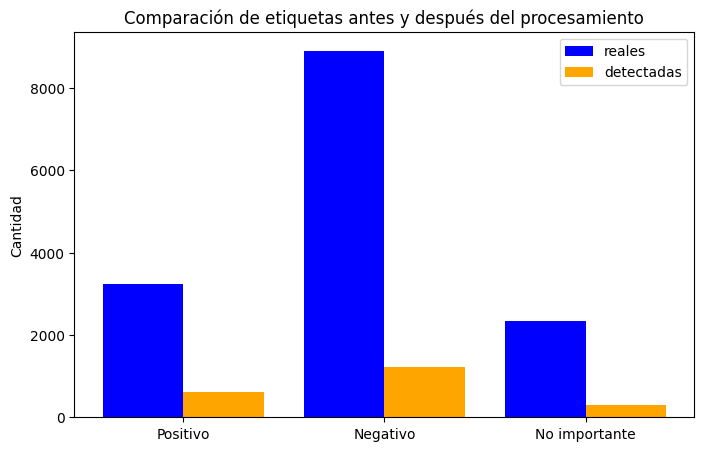

In [46]:
#comparacion de anotaciones reales y detectadas con cellpose
clases = ['Negativos', 'Positivos', 'No Importantes']
reales = annotations['Label'].value_counts()

# Datos antes del procesamiento
cantidad_positivos = (annotations['Label'] == 'Positivo').sum()
cantidad_negativos = (annotations['Label'] == 'Negativo').sum()
cantidad_no_importante = (annotations['Label'] == 'No importante').sum()

# Datos después del procesamiento
conteo_clases = df['Label'].value_counts()

# Crear listas de valores
categorias = ['Positivo', 'Negativo', 'No importante']
valores_antes = [cantidad_positivos, cantidad_negativos, cantidad_no_importante]
valores_despues = [conteo_clases.get('Positivo', 0), conteo_clases.get('Negativo', 0), conteo_clases.get('No importante', 0)]

# Posiciones en el eje X
x = np.arange(len(categorias))

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, valores_antes, width=0.4, label='reales', color='blue')
plt.bar(x + 0.2, valores_despues, width=0.4, label='detectadas', color='orange')

# Etiquetas y título
plt.xticks(x, categorias)
plt.ylabel('Cantidad')
plt.title('Comparación de etiquetas antes y después del procesamiento')
plt.legend()
plt.show()

In [47]:
# Calcular la proporción de diferencia
diferencia_porcentaje = [(r - p) / r * 100 for r, p in zip(reales, conteo_clases)]

# Mostrar los resultados
for clase, diferencia in zip(clases, diferencia_porcentaje):
    print(f'Clase: {clase} - Diferencia porcentual: {diferencia:.2f}%')

Clase: Negativos - Diferencia porcentual: 86.39%
Clase: Positivos - Diferencia porcentual: 81.36%
Clase: No Importantes - Diferencia porcentual: 87.15%


Procesamiento de datos para entrenar modelo XGBoost

In [48]:
df.shape

(2118, 14)

MinMaxScaler

In [49]:
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=['Label', 'imagen_sin_tif'])
y= df['Label']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [51]:
X_scaled_df.head()

,area,perimetro,excentricidad,solidez,X,Y,eje_mayor,eje_menor,orientacion,extent,area_convexa,distancia_vecino
0,0.066789,0.205318,0.745904,0.883297,0.096607,0.004386,0.167018,0.185433,0.051475,0.822979,0.065764,0.035146
1,0.306612,0.499060,0.640035,0.916534,0.182834,0.029605,0.374698,0.505294,0.375802,0.690216,0.299913,0.157759
2,0.033643,0.129108,0.759128,0.874274,0.432735,0.077303,0.109692,0.113619,0.005166,0.777844,0.033157,0.048880
3,0.215983,0.429268,0.634025,0.800031,0.185629,0.149671,0.311089,0.422274,0.240210,0.639641,0.217217,0.071778
4,0.159080,0.378928,0.838837,0.765040,0.016766,0.168311,0.323083,0.294053,0.286198,0.493666,0.161377,0.088459


Label Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
y_encoded = le.fit_transform(y)

In [ ]:
y_df = pd.DataFrame({"Label": y, "encoded_label": y_encoded})
y_df.head()

In [ ]:
y_df.value_counts()

Train/test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

Undersampling clase 'Negativo' -

In [ ]:
from imblearn.under_sampling import RandomUnderSampler


undersampler = RandomUnderSampler(sampling_strategy={0: 2500}, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Verificar el nuevo balance
pd.Series(y_train_resampled).value_counts()

XGBoost

Inicializacion del modelo

In [ ]:
import xgboost as xgb

params = {
    "objective": "multi:softmax",  # Clasificación multiclase
    "num_class": 3,  # Número de clases
    "max_depth": 6,  # Profundidad del árbol
    "learning_rate": 0.1,  # Tasa de aprendizaje
    "n_estimators": 100,  # Número de árboles
    "eval_metric": "mlogloss",  # Métrica de evaluación
    "random_state": 42
}

# Inicializar el modelo con parámetros definidos
model_class = xgb.XGBClassifier(**params)

# Entrenar el modelo
model_class.fit(X_train, y_train)

# Predicciones
y_pred = model_class.predict(X_test)

Parametros de rendimiento

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.4f}")


report = classification_report(y_test, y_pred)
print(report)